In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class MultiProductInventoryEnv(gym.Env):
    """
    Gymnasium Environment for multi-product inventory management with perishable goods and dynamic discounting.
    - Manages multiple products with given shelf lives.
    - Applies dynamic discounting if stock is high or demand is low (increasing sales at reduced profit).
    - Enforces a daily budget constraint on orders.
    """
    def __init__(self, num_products=5, shelf_lives=None, base_demand=None,
                 price=None, cost=None, discount_rate=0.2,
                 season_period=30, season_amplitude=0.3,
                 budget=50, max_order=5, horizon=100):
        super().__init__()
        # Default parameters for 5 products
        if shelf_lives is None:
            shelf_lives = [3, 5, 7, 4, 6]  # shelf life (in days) for each of the 5 products
        if base_demand is None:
            base_demand = [5, 8, 3, 6, 4]  # average daily demand for each product
        self.num_products = num_products
        self.shelf_lives = np.array(shelf_lives, dtype=int)
        self.base_demand = np.array(base_demand, dtype=float)
        # Cost to order each unit of product, and selling price per unit
        if cost is None:
            self.cost = np.ones(self.num_products, dtype=float)  # assume cost 1 per unit for all products
        else:
            self.cost = np.array(cost, dtype=float)
        if price is None:
            self.price = self.cost * 2.0  # default: 100% markup (price double the cost)
        else:
            self.price = np.array(price, dtype=float)
        # Dynamic discount rate (fraction price reduction when discounting)
        self.discount_rate = discount_rate
        # Seasonality parameters for demand variation
        self.season_period = season_period       # period of seasonal demand fluctuation (days)
        self.season_amplitude = season_amplitude # amplitude of seasonal demand swings
        # Daily budget constraint for ordering (maximum money that can be spent per day on orders)
        self.budget = budget
        # Action space: how many units to order for each product (discrete 0..max_order for each product)
        self.max_order = max_order
        # Episode length (number of days before episode termination)
        self.horizon = horizon

        # Define Gym spaces
        # Each action is a vector of length num_products with an integer order quantity for each product
        self.action_space = spaces.MultiDiscrete([max_order + 1] * self.num_products)
        # Observation space: includes inventory levels and seasonal factors.
        # Inventory levels (for 5 products) and two seasonal indicators (sin, cos of seasonal phase)
        # We set reasonable bounds for inventory (0 to 1.5 * max_order * shelf_life) and -1 to 1 for sin/cos.
        max_inventory = np.array([1.5 * max_order * self.shelf_lives[i] + 1 for i in range(self.num_products)], dtype=np.float32)
        low = np.concatenate((np.zeros(self.num_products, dtype=np.float32), np.array([-1.0, -1.0], dtype=np.float32)))
        high = np.concatenate((max_inventory, np.array([1.0, 1.0], dtype=np.float32)))
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Initialize state variables
        self.day = 0  # current day index in the episode
        # Inventory tracked by age for each product (list of lists: each list length = shelf_life of that product)
        self.inventory_by_age = [ [0] * self.shelf_lives[i] for i in range(self.num_products) ]
        self.discount_active = [False] * self.num_products  # track which products have discount active on a given day

    def reset(self, seed=None, options=None):
        """Reset the environment at the start of an episode."""
        super().reset(seed=seed)
        self.day = 0
        # Reset all inventory to zero
        self.inventory_by_age = [ [0] * self.shelf_lives[i] for i in range(self.num_products) ]
        self.discount_active = [False] * self.num_products
        # Return initial observation
        return self._get_obs(), {}

    def _get_obs(self):
        """Construct the current state observation."""
        # Total inventory of each product
        inv_levels = [sum(self.inventory_by_age[i]) for i in range(self.num_products)]
        # Seasonal factors (sine and cosine of current phase) to indicate demand phase
        season_phase = (self.day % self.season_period) / self.season_period  # fraction of the seasonal period
        sin_term = np.sin(2 * np.pi * season_phase)
        cos_term = np.cos(2 * np.pi * season_phase)
        return np.array(inv_levels + [sin_term, cos_term], dtype=np.float32)

    def step(self, action):
        """Simulate one day (step) in the environment given an action (order quantities for each product)."""
        orders = np.array(action, dtype=int)
        # Enforce budget constraint: if total order cost exceeds budget, scale down proportionally
        total_cost = float(np.dot(self.cost, orders))
        if total_cost > self.budget:
            scale = self.budget / total_cost if total_cost > 0 else 0.0
            orders = np.floor(orders * scale).astype(int)
            total_cost = float(np.dot(self.cost, orders))
        order_cost = total_cost  # total cost spent on orders today

        # Receive ordered products (added to inventory at age 0)
        for i in range(self.num_products):
            self.inventory_by_age[i][0] += int(orders[i])

        # Generate stochastic demand for each product
        # Base demand adjusted by a seasonal factor (sinusoidal variation)
        season_phase = (self.day % self.season_period) / self.season_period
        season_factor = 1 + self.season_amplitude * np.sin(2 * np.pi * season_phase)
        demands = []
        for i in range(self.num_products):
            mean_demand = self.base_demand[i] * season_factor
            # Use Poisson distribution to sample daily demand (non-negative integer, with given mean)
            demand = np.random.poisson(lam=mean_demand)
            demands.append(demand)

        # Determine dynamic discounting: activate discount if stock is high or demand is in a low season
        self.discount_active = [False] * self.num_products
        for i in range(self.num_products):
            # Condition 1: High stock (inventory > 2 * base demand)
            high_stock = sum(self.inventory_by_age[i]) > 2 * self.base_demand[i]
            # Condition 2: Low demand period (season factor significantly below average)
            low_demand_period = season_factor < 0.8
            if high_stock or low_demand_period:
                self.discount_active[i] = True

        # Apply discount effects: increase demand if discount is active (at cost of lower price per unit)
        for i in range(self.num_products):
            if self.discount_active[i]:
                # Increase demand by a fraction (e.g., 20% more if discount_rate=0.2) to simulate price sensitivity
                extra_demand = int(np.floor(demands[i] * self.discount_rate))
                demands[i] += extra_demand
                # (Revenue impact of discount is handled by reducing unit price during sales)

        # Fulfill demand from inventory (sell items, using oldest stock first to minimize waste)
        revenue = 0.0
        for i in range(self.num_products):
            demand = demands[i]
            if demand <= 0:
                continue
            # Iterate over inventory ages from oldest to newest (highest age index to 0)
            for age in range(self.shelf_lives[i] - 1, -1, -1):
                if demand <= 0:
                    break
                available = self.inventory_by_age[i][age]
                if available <= 0:
                    continue
                # Sell as many units as possible from this age group
                sold = min(available, demand)
                self.inventory_by_age[i][age] -= sold
                demand -= sold
                # Calculate revenue: use discounted price if discount is active for this product
                unit_price = self.price[i] * (1 - self.discount_rate) if self.discount_active[i] else self.price[i]
                revenue += sold * unit_price
            # Any remaining demand (if demand > supply) is lost sales (no penalty in reward beyond lost revenue)

        # Age the remaining inventory and remove expired stock
        expired = [0] * self.num_products
        for i in range(self.num_products):
            # Remove inventory that has reached the end of its shelf life (last age bucket)
            expired[i] = self.inventory_by_age[i].pop(-1)
            # Shift inventory: advance age for remaining stock by inserting an empty 0-age slot at the front
            self.inventory_by_age[i].insert(0, 0)
            # (Expired items had been counted in cost when ordered, and yield no revenue. We could add a disposal cost if needed.)

        # Compute reward for this step: profit = revenue from sales - cost of orders 
        # (Holding or expiration costs could be included as additional penalties if desired)
        reward = revenue - order_cost

        # Increment day counter
        self.day += 1
        # Check if episode is done (time horizon reached)
        terminated = False  # We have no other termination condition (no bankruptcy or such in this setup)
        truncated = (self.day >= self.horizon)  # end of episode due to horizon
        # Observe new state
        obs = self._get_obs()
        info = {"revenue": revenue, "order_cost": order_cost, "expired": expired, "discount_active": self.discount_active}
        return obs, reward, terminated, truncated, info


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# Replay Buffer for experience replay
class ReplayBuffer:
    def __init__(self, state_dim, max_size=10000):
        self.max_size = max_size
        self.state_dim = state_dim
        self.ptr = 0
        self.size = 0
        # Allocate memory for transitions
        self.states = np.zeros((max_size, state_dim), dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.int64)
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.next_states = np.zeros((max_size, state_dim), dtype=np.float32)
        self.dones = np.zeros(max_size, dtype=np.float32)
    def add(self, state, action, reward, next_state, done):
        """Add a new transition to the buffer (overwrites old experiences if buffer is full)."""
        idx = self.ptr
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = float(done)
        # Update write pointer and size
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    def sample(self, batch_size):
        """Randomly sample a batch of transitions from the buffer."""
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch_states = torch.tensor(self.states[idxs], dtype=torch.float32)
        batch_actions = torch.tensor(self.actions[idxs], dtype=torch.int64)
        batch_rewards = torch.tensor(self.rewards[idxs], dtype=torch.float32)
        batch_next_states = torch.tensor(self.next_states[idxs], dtype=torch.float32)
        batch_dones = torch.tensor(self.dones[idxs], dtype=torch.float32)
        return batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones

# Q-Network definition (3 fully connected hidden layers)
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        # Neural network with three hidden layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.out = nn.Linear(128, output_dim)
    def forward(self, x):
        # Forward pass with ReLU activations
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.out(x)

# DQN Agent that uses the QNetwork and ReplayBuffer
class DQNAgent:
    def __init__(self, state_dim, num_products, max_order,
                 gamma=0.99, lr=1e-3,
                 epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999,
                 batch_size=64, target_update_freq=1000, buffer_size=10000):
        # Dimensions and parameters
        self.state_dim = state_dim
        self.num_products = num_products
        self.max_order = max_order
        # Total number of discrete actions = (max_order+1) ^ num_products (all combinations of order quantities)
        self.action_dim = (max_order + 1) ** num_products

        # Initialize Q-networks
        self.policy_net = QNetwork(state_dim, self.action_dim)
        self.target_net = QNetwork(state_dim, self.action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # start target_net with same weights
        self.target_net.eval()  # target network is used for predictions only

        # Hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon_start  # starting epsilon for exploration
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay  # decay factor per step (multiplied each update)
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Experience replay buffer
        self.replay_buffer = ReplayBuffer(state_dim, max_size=buffer_size)
        # Optimizer for the policy network
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        # Internal step counter for learning updates
        self.train_step_count = 0

    def select_action(self, state):
        """Select an action (as an index) using epsilon-greedy strategy given the current state."""
        if random.random() < self.epsilon:
            # Explore: choose a random action index
            action_idx = random.randrange(self.action_dim)
        else:
            # Exploit: choose the best action from Q-network
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # shape [1, state_dim]
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            action_idx = int(torch.argmax(q_values, dim=1).item())
        return action_idx

    def idx_to_action(self, action_idx):
        """Convert a discrete action index into the multi-product order vector (length = num_products)."""
        actions = []
        base = self.max_order + 1  # base for each digit (number of choices per product)
        for _ in range(self.num_products):
            actions.append(action_idx % base)
            action_idx //= base
        # `actions` now holds the order quantities for each product (product 0 through num_products-1)
        return actions

    def train_step(self):
        """Perform one training step of DQN: sample replay buffer, update network weights."""
        if self.replay_buffer.size < self.batch_size:
            # Not enough samples to train yet
            return
        # Sample a batch of transitions from replay memory
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Compute current Q values for the actions taken
        # q_values has shape [batch_size, action_dim]
        q_values = self.policy_net(states)
        # Gather Q-values for the specific actions from the batch (index along action_dim)
        # actions shape [batch_size] -> need unsqueeze to [batch_size,1] for gather
        q_action = q_values.gather(1, actions.view(-1, 1)).squeeze(1)

        # Compute target Q values using the target network
        with torch.no_grad():
            # Get max Q for next state from target network
            next_q_values = self.target_net(next_states)
            max_next_q = torch.max(next_q_values, dim=1)[0]  # maximum Q-value for each next state
            # If done, we use 0 for future reward; if not done, include discounted max next Q
            target = rewards + self.gamma * max_next_q * (1 - dones)

        # Compute loss (Huber loss for stability)
        loss = nn.functional.smooth_l1_loss(q_action, target)

        # Gradient descent step on policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network periodically
        self.train_step_count += 1
        if self.train_step_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        # Decay epsilon after each training step (for exploration-exploitation tradeoff)
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay


In [3]:
# Initialize environment and agent
env = MultiProductInventoryEnv()
state_dim = env.observation_space.shape[0]
num_products = env.num_products
max_order = env.max_order

agent = DQNAgent(state_dim, num_products, max_order,
                 gamma=0.99, lr=1e-3,
                 epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999,
                 batch_size=64, target_update_freq=500, buffer_size=10000)

# Set random seeds for reproducibility (optional)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Training parameters
num_episodes = 500        # number of episodes (days sequences) to train
print_interval = 50       # how often to print progress
total_rewards = []        # track total reward (profit) per episode

for episode in range(1, num_episodes+1):
    state, _ = env.reset()        # reset environment at start of episode
    episode_reward = 0.0
    # Run one episode (iterate over days)
    while True:
        # Choose action (order quantities for each product) using DQN agent
        action_idx = agent.select_action(state)
        action_vec = agent.idx_to_action(action_idx)
        # Take action in environment
        next_state, reward, terminated, truncated, info = env.step(action_vec)
        done = terminated or truncated
        # Store transition in replay buffer
        agent.replay_buffer.add(state, action_idx, reward, next_state, done)
        # Train the agent on a sampled batch (if enough data)
        agent.train_step()
        # Update state and accumulated reward
        state = next_state
        episode_reward += reward
        if done:
            break

    total_rewards.append(episode_reward)
    # Print training progress every few episodes
    if episode % print_interval == 0:
        avg_reward = np.mean(total_rewards[-print_interval:])
        print(f"Episode {episode}/{num_episodes}, Average Reward (last {print_interval} eps): {avg_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

# After training, evaluate the learned policy (greedy actions)
agent.epsilon = 0.0  # disable exploration for evaluation
state, _ = env.reset()
test_reward = 0.0
while True:
    action_idx = agent.select_action(state)              # select best action
    action_vec = agent.idx_to_action(action_idx)
    next_state, reward, terminated, truncated, info = env.step(action_vec)
    test_reward += reward
    state = next_state
    if terminated or truncated:
        break
print(f"Total reward in one evaluation episode: {test_reward:.2f}")


Episode 50/500, Average Reward (last 50 eps): 1157.50, Epsilon: 0.10
Episode 100/500, Average Reward (last 50 eps): 1013.35, Epsilon: 0.10
Episode 150/500, Average Reward (last 50 eps): 971.78, Epsilon: 0.10
Episode 200/500, Average Reward (last 50 eps): 1027.14, Epsilon: 0.10
Episode 250/500, Average Reward (last 50 eps): 1056.68, Epsilon: 0.10
Episode 300/500, Average Reward (last 50 eps): 1020.46, Epsilon: 0.10
Episode 350/500, Average Reward (last 50 eps): 999.99, Epsilon: 0.10
Episode 400/500, Average Reward (last 50 eps): 1028.22, Epsilon: 0.10
Episode 450/500, Average Reward (last 50 eps): 978.96, Epsilon: 0.10
Episode 500/500, Average Reward (last 50 eps): 1011.29, Epsilon: 0.10
Total reward in one evaluation episode: 904.40


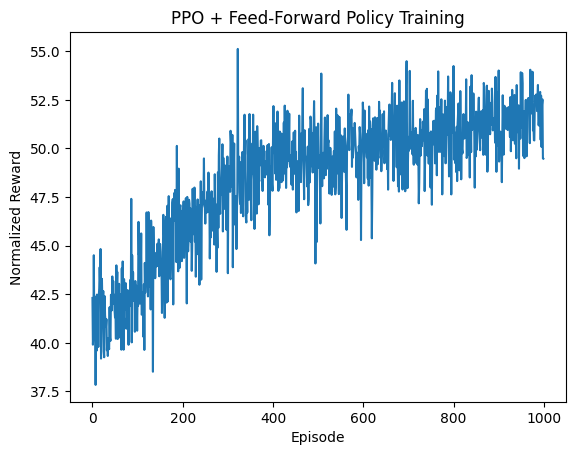

In [15]:
#!/usr/bin/env python3
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# ------------------------------
# 1. Environment with reduced stochasticity
# ------------------------------
class MultiProductInventoryEnvV4(gym.Env):
    def __init__(self,
                 num_products=5,
                 base_budget=500,
                 order_cost=7.0,
                 full_price=10.0,
                 discount_price=5.0,
                 waste_penalty=3.0,
                 promo_prob=0.02,
                 slump_prob=0.02,
                 max_days=100,
                 seed=None):
        super().__init__()
        self.num_products   = num_products
        self.max_order      = 10
        self.base_budget    = base_budget
        self.order_cost     = order_cost
        self.full_price     = full_price
        self.discount_price = discount_price
        self.waste_penalty  = waste_penalty
        self.promo_prob     = promo_prob
        self.slump_prob     = slump_prob
        self.max_days       = max_days
        self.discount_threshold = 20

        # fixed shelf life for all products
        self.shelf_lives = [7] * num_products

        # observation / action spaces
        obs_dim = sum(self.shelf_lives)
        self.observation_space = gym.spaces.Box(
            low=0, high=1000, shape=(obs_dim,), dtype=np.float32
        )
        self.action_space = gym.spaces.MultiDiscrete(
            [self.max_order + 1] * num_products
        )

        self.seed(seed)
        self.reset()

    def seed(self, seed=None):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self, *, seed=None, options=None):
        self.day = 0
        # on-hand inventory per age bucket
        self.inventory = [np.zeros(life, dtype=int) for life in self.shelf_lives]
        # deterministic base demand means
        self.base_demand = np.linspace(4.0, 8.0, self.num_products)
        return self._get_obs(), {}

    def _get_obs(self):
        return np.concatenate(self.inventory).astype(np.float32)

    def _sample_demand(self, idx):
        μ = self.base_demand[idx]
        if random.random() < 0.8:
            # mostly Poisson
            return np.random.poisson(μ)
        else:
            # small Normal bump
            return max(0, int(round(np.random.normal(μ, 1.0))))

    def step(self, action):
        # promotions & slumps (flags only, no lasting effect)
        _ = [random.random() < self.promo_prob for _ in range(self.num_products)]
        _ = [random.random() < self.slump_prob for _ in range(self.num_products)]

        # age & compute waste
        expired = 0
        for i in range(self.num_products):
            expired += int(self.inventory[i][-1])
            self.inventory[i][1:] = self.inventory[i][:-1]
            self.inventory[i][0]  = 0

        # ordering (deterministic budget and cost)
        daily_budget = self.base_budget
        delivered = np.minimum(action, int(daily_budget // self.order_cost))
        for i, qty in enumerate(delivered):
            self.inventory[i][0] += int(qty)
            daily_budget     -= qty * self.order_cost

        # demand & sales
        revenue = 0.0
        for i in range(self.num_products):
            demand = self._sample_demand(i)
            inv = self.inventory[i]
            for age in reversed(range(len(inv))):
                if demand <= 0:
                    break
                available = inv[age]
                sell = min(available, demand)
                price = (
                    self.discount_price
                    if age >= (len(inv) - 3)  else self.full_price
                )
                revenue += sell * price
                inv[age] -= sell
                demand  -= sell
            self.inventory[i] = inv

        # reward
        reward = (revenue - self.waste_penalty * expired) / self.base_budget

        self.day += 1
        done = (self.day >= self.max_days)
        obs  = self._get_obs().copy()
        info = {"expired": expired}
        return obs, reward, done, info


# ------------------------------
# 2. Feed‐forward Policy & Value Networks
# ------------------------------
class FeedForwardPolicy(nn.Module):
    def __init__(self, input_dim, action_sizes, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, sum(action_sizes))
        )
        self.action_sizes = action_sizes

    def forward(self, x):
        logits = self.net(x)
        return torch.split(logits, self.action_sizes, dim=-1)


class FeedForwardValue(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


# ------------------------------
# 3. PPO Training Loop
# ------------------------------
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # instantiate environment correctly
    env = MultiProductInventoryEnvV4()
    obs, _ = env.reset()

    state_dim    = obs.shape[0]
    action_sizes = [int(n) for n in env.action_space.nvec]

    policy   = FeedForwardPolicy(state_dim, action_sizes).to(device)
    value_fn = FeedForwardValue(state_dim).to(device)

    optim_p = optim.Adam(policy.parameters(), lr=3e-4)
    optim_v = optim.Adam(value_fn.parameters(), lr=1e-3)

    # PPO hyperparameters
    gamma, lam       = 0.99, 0.95
    clip, ent_coef   = 0.2, 0.02
    vf_coef          = 0.5
    epochs, batch_sz = 10, 2000
    max_episodes     = 1000

    # storage
    S, A, LP, V, R, D = [], [], [], [], [], []
    ep_rewards = []
    ep, t, ep_r = 0, 0, 0

    state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

    while ep < max_episodes:
        # collect one step
        logits = policy(state)
        logp   = 0
        acts   = []
        for lg in logits:
            dist = Categorical(logits=lg)
            a    = dist.sample()
            acts.append(a.item())
            logp += dist.log_prob(a)
        val = value_fn(state)

        nxt_obs, reward, done, _ = env.step(acts)
        nxt = torch.tensor(nxt_obs, dtype=torch.float32, device=device).unsqueeze(0)

        # store
        S.append(state.cpu().numpy().squeeze(0))
        A.append(acts)
        LP.append(logp.item())
        V.append(val.item())
        R.append(reward)
        D.append(done)

        state = nxt
        ep_r  += reward
        t     += 1

        if done:
            ep_rewards.append(ep_r)
            ep   += 1
            ep_r  = 0
            obs,_ = env.reset()
            state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

        if t >= batch_sz:
            with torch.no_grad():
                last_val = 0.0 if done else value_fn(state).item()

            # compute GAE & returns
            advs, gae = [], 0
            for i in reversed(range(len(R))):
                mask   = 0.0 if D[i] else 1.0
                nxt_v  = last_val if i == len(R)-1 else V[i+1]
                delta  = R[i] + gamma*nxt_v*mask - V[i]
                gae    = delta + gamma*lam*mask*gae
                advs.insert(0, gae)
                if D[i]:
                    gae = 0
            advs = torch.tensor(advs, dtype=torch.float32, device=device)
            advs = (advs - advs.mean())/(advs.std() + 1e-8)
            rets = advs + torch.tensor(V, dtype=torch.float32, device=device)

            # batch tensors
            St    = torch.tensor(np.array(S), dtype=torch.float32, device=device)
            At    = torch.tensor(np.array(A), dtype=torch.int64,   device=device)
            OldLP = torch.tensor(LP, dtype=torch.float32, device=device)

            # PPO epochs
            for _ in range(epochs):
                logits_b = policy(St)
                newLP, ent = [], 0
                for i, lg in enumerate(logits_b):
                    dist = Categorical(logits=lg)
                    newLP.append(dist.log_prob(At[:,i]))
                    ent   += dist.entropy().mean()
                newLP = torch.stack(newLP, dim=1).sum(dim=1)

                vals_b = value_fn(St)

                ratio        = torch.exp(newLP - OldLP)
                obj1         = ratio * advs
                obj2         = torch.clamp(ratio, 1-clip, 1+clip) * advs
                policy_loss  = -torch.mean(torch.min(obj1, obj2))
                value_loss   = torch.mean((vals_b - rets)**2)
                loss         = policy_loss + vf_coef*value_loss - ent_coef*ent

                optim_p.zero_grad()
                optim_v.zero_grad()
                loss.backward()
                optim_p.step()
                optim_v.step()

            S, A, LP, V, R, D = [], [], [], [], [], []
            t = 0

    # plot learning curve
    plt.plot(ep_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Normalized Reward")
    plt.title("PPO + Feed-Forward Policy Training")
    plt.show()


if __name__ == "__main__":
    train()


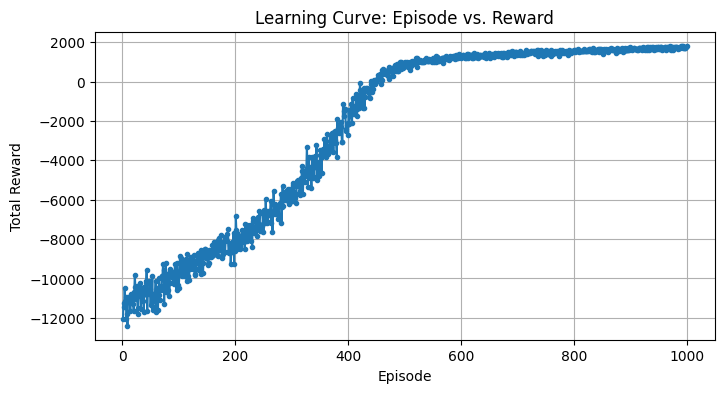

In [16]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt


class MultiProductInventoryEnv(gym.Env):
    """
    Gymnasium Environment for multi-product perishable inventory management.
    """
    def __init__(self, num_products=5, shelf_lives=None, max_order=10, budget=50,
                 full_price=10.0, discount_price=5.0, order_cost=7.0, waste_penalty=3.0,
                 demand_lambdas=None, promo_factor=2.0, slump_factor=0.2,
                 promo_prob=0.05, slump_prob=0.05, max_days=100, seed=None):
        super().__init__()
        if shelf_lives is None:
            shelf_lives = [3, 5, 7, 4, 6][:num_products]
        self.num_products   = num_products
        self.shelf_lives    = shelf_lives
        self.max_order      = max_order
        self.budget         = budget
        self.full_price     = full_price
        self.discount_price = discount_price
        self.order_cost     = order_cost
        self.waste_penalty  = waste_penalty

        if demand_lambdas is None:
            demand_lambdas = [5, 8, 6, 4, 7][:num_products]
        self.demand_lambdas = np.array(demand_lambdas, dtype=float)

        self.promo_factor   = promo_factor
        self.slump_factor   = slump_factor
        self.promo_prob     = promo_prob
        self.slump_prob     = slump_prob
        self.max_days       = max_days
        self.discount_threshold = 20

        # spaces
        self.action_space = spaces.MultiDiscrete([max_order + 1] * num_products)
        obs_dim = sum(self.shelf_lives)
        self.observation_space = spaces.Box(0, 1000, (obs_dim,), dtype=np.float32)

        self.seed(seed)
        self.reset()

    def seed(self, seed=None):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self):
        self.day = 0
        self.inventory = [np.zeros(life, dtype=int) for life in self.shelf_lives]
        return self._get_obs(), {}

    def _get_obs(self):
        return np.concatenate(self.inventory).astype(np.float32)

    def step(self, action):
        orders = np.clip(np.array(action, int), 0, self.max_order)
        reward = 0.0

        # 1) Aging & expiration
        expired_total = 0
        for i in range(self.num_products):
            inv = self.inventory[i]
            expired = int(inv[-1])
            if expired > 0:
                reward -= self.waste_penalty * expired
            expired_total += expired
            if len(inv) > 1:
                inv[1:] = inv[:-1]
            inv[0] = 0
            self.inventory[i] = inv

        # 2) Budget & ordering
        total_cost = self.order_cost * orders.sum()
        delivered = np.zeros_like(orders)
        remaining_budget = self.budget
        for i in range(self.num_products):
            max_afford = int(remaining_budget // self.order_cost)
            delivered[i] = min(orders[i], max_afford)
            remaining_budget -= delivered[i] * self.order_cost
        delivered_cost = delivered.sum() * self.order_cost
        overshoot = total_cost - delivered_cost
        if overshoot > 0:
            reward -= overshoot
        reward -= delivered_cost

        for i in range(self.num_products):
            self.inventory[i][0] += int(delivered[i])

        # 3) Demand & sales
        total_revenue = 0.0
        for i in range(self.num_products):
            lam = self.demand_lambdas[i]
            r = random.random()
            if r < self.slump_prob:
                lam *= self.slump_factor
            elif r < self.slump_prob + self.promo_prob:
                lam *= self.promo_factor
            demand = np.random.poisson(lam)

            inv = self.inventory[i]
            L = len(inv)
            total_inv = inv.sum()
            discount_tier = 2 if total_inv > self.discount_threshold else 1

            revenue = 0.0
            for age_idx in range(L-1, -1, -1):
                if demand <= 0:
                    break
                avail = int(inv[age_idx])
                if avail <= 0:
                    continue
                sell_qty = min(avail, demand)
                remaining_days = L - age_idx
                price = (self.discount_price
                         if remaining_days <= discount_tier
                         else self.full_price)
                revenue += sell_qty * price
                inv[age_idx] -= sell_qty
                demand -= sell_qty
            self.inventory[i] = inv
            total_revenue += revenue

        reward += total_revenue
        self.day += 1
        done = (self.day >= self.max_days)
        info = {"expired_items": expired_total, "revenue": total_revenue}
        return self._get_obs(), reward, done, info


# --------------------------------------
# 2. Policy & Value Networks
# --------------------------------------
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_sizes):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc_logits = nn.Linear(128, sum(action_sizes))
        self.action_sizes = action_sizes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc_logits(x)
        return torch.split(logits, self.action_sizes, dim=-1)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc_value = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc_value(x).squeeze(-1)


# --------------------------------------
# 3. PPO Training + Episode‐Reward Plot
# --------------------------------------
def train_and_plot():
    env = MultiProductInventoryEnv()
    state_dim = env.observation_space.shape[0]
    action_sizes = [int(n) for n in env.action_space.nvec]

    policy_net = PolicyNetwork(state_dim, action_sizes)
    value_net  = ValueNetwork(state_dim)
    policy_opt = optim.Adam(policy_net.parameters(), lr=3e-4)
    value_opt  = optim.Adam(value_net.parameters(),  lr=1e-3)

    # PPO hyperparams
    gamma, lam       = 0.99, 0.95
    clip_eps, ent_wt = 0.2, 0.0
    vf_wt            = 0.5
    epochs, batch_sz = 5, 1000
    max_eps          = 1000

    episode_rewards = []
    buffer = {'states':[], 'actions':[], 'logps':[], 'values':[], 'rewards':[], 'dones':[]}
    eps, t, ep_r = 0, 0, 0.0

    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32)

    while eps < max_eps:
        # ---- collect a step ----
        logits = policy_net(state)
        total_logp = 0
        acts = []
        for lg in logits:
            dist = Categorical(logits=lg)
            a = dist.sample()
            acts.append(a.item())
            total_logp += dist.log_prob(a)
        val = value_net(state)

        nxt_state, rew, done, _ = env.step(acts)
        nxt_state = torch.tensor(nxt_state, dtype=torch.float32)

        # store
        buffer['states'].append(state.numpy())
        buffer['actions'].append(acts)
        buffer['logps'].append(total_logp.item())
        buffer['values'].append(val.item())
        buffer['rewards'].append(rew)
        buffer['dones'].append(done)

        state = nxt_state
        ep_r += rew
        t += 1

        if done:
            episode_rewards.append(ep_r)
            eps += 1
            ep_r = 0.0
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float32)
            done = False

        if t >= batch_sz:
            # compute GAE & returns
            with torch.no_grad():
                last_val = 0.0 if done else value_net(state).item()

            advs, gae = [], 0.0
            for i in reversed(range(len(buffer['rewards']))):
                mask = 0.0 if buffer['dones'][i] else 1.0
                next_val = last_val if i == len(buffer['rewards'])-1 else buffer['values'][i+1]
                delta = buffer['rewards'][i] + gamma*next_val*mask - buffer['values'][i]
                gae = delta + gamma*lam*mask*gae
                advs.insert(0, gae)
                if buffer['dones'][i]:
                    gae = 0.0

            advs    = torch.tensor(advs, dtype=torch.float32)
            advs    = (advs - advs.mean())/(advs.std()+1e-8)
            returns = advs + torch.tensor(buffer['values'], dtype=torch.float32)

            states_t = torch.tensor(np.array(buffer['states']), dtype=torch.float32)
            actions_t= torch.tensor(np.array(buffer['actions']), dtype=torch.int64)
            old_logp = torch.tensor(buffer['logps'], dtype=torch.float32)

            # PPO update
            for _ in range(epochs):
                logits_b = policy_net(states_t)
                new_logp, ent = [], 0.0
                for i, lg in enumerate(logits_b):
                    dist = Categorical(logits=lg)
                    new_logp.append(dist.log_prob(actions_t[:,i]))
                    ent += dist.entropy().mean()
                new_logp = torch.stack(new_logp, dim=1).sum(dim=1)

                vals_b = value_net(states_t)

                ratio = torch.exp(new_logp - old_logp)
                obj1, obj2 = ratio*advs, torch.clamp(ratio,1-clip_eps,1+clip_eps)*advs
                p_loss = -torch.mean(torch.min(obj1, obj2))
                v_loss = torch.mean((vals_b - returns)**2)
                loss   = p_loss + vf_wt*v_loss - ent_wt*ent

                policy_opt.zero_grad()
                value_opt.zero_grad()
                loss.backward()
                policy_opt.step()
                value_opt.step()

            # reset buffer
            for k in buffer: buffer[k].clear()
            t = 0

    # ---- Plot Episode vs. Reward ----
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(episode_rewards)+1), episode_rewards, marker='.')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Learning Curve: Episode vs. Reward")
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    train_and_plot()


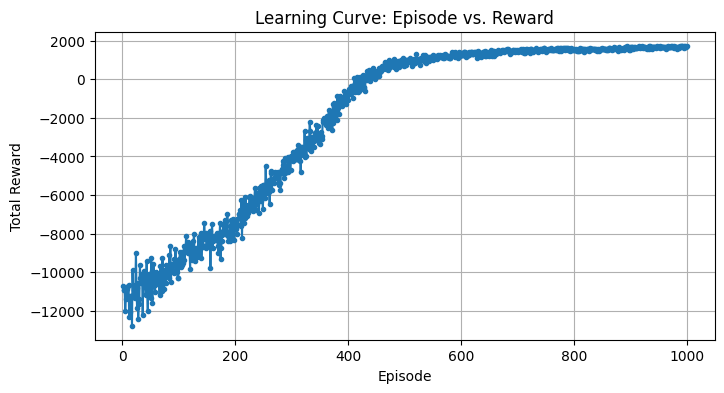

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt


class MultiProductInventoryEnvRealistic(gym.Env):
    def __init__(self,
                 num_products=5,
                 shelf_lives=None,
                 max_order=10,
                 budget=50,
                 full_price=10.0,
                 discount_price=5.0,
                 order_cost=7.0,
                 waste_penalty=3.0,
                 demand_lambdas=None,
                 promo_factor=2.0,
                 slump_factor=0.2,
                 promo_prob=0.10,           # ↑ from 0.05
                 slump_prob=0.10,           # ↑ from 0.05
                 max_days=100,
                 seed=None,
                 sale_reward_coef=1.0,      # new
                 living_penalty_coef=0.05   # new
                 ):
        super().__init__()
        if shelf_lives is None:
            shelf_lives = [3,5,7,4,6][:num_products]
        self.num_products         = num_products
        self.shelf_lives          = shelf_lives
        self.max_order            = max_order
        self.base_budget          = budget
        self.full_price           = full_price
        self.discount_price       = discount_price
        self.order_cost           = order_cost
        self.waste_penalty        = waste_penalty
        if demand_lambdas is None:
            demand_lambdas = [5,8,6,4,7][:num_products]
        self.demand_lambdas       = np.array(demand_lambdas, float)
        self.promo_factor         = promo_factor
        self.slump_factor         = slump_factor
        self.promo_prob           = promo_prob
        self.slump_prob           = slump_prob
        self.max_days             = max_days
        self.discount_threshold   = 20
        self.sale_reward_coef     = sale_reward_coef
        self.living_penalty_coef  = living_penalty_coef

        # spaces
        self.action_space         = spaces.MultiDiscrete([max_order+1]*num_products)
        obs_dim                   = sum(self.shelf_lives)
        self.observation_space    = spaces.Box(0,1000,(obs_dim,),dtype=np.float32)

        self.seed(seed)
        self.reset()

    def seed(self, seed=None):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self):
        self.day       = 0
        self.inventory = [np.zeros(life, int) for life in self.shelf_lives]
        return self._get_obs(), {}

    def _get_obs(self):
        return np.concatenate(self.inventory).astype(np.float32)

    def step(self, action):
        orders = np.clip(np.array(action, int), 0, self.max_order)

        # 1) Age & expire
        expired_total = 0
        for i in range(self.num_products):
            inv = self.inventory[i]
            expired = int(inv[-1])
            expired_total += expired
            # shift
            if len(inv)>1:
                inv[1:] = inv[:-1]
            inv[0] = 0
            self.inventory[i] = inv

        # 2) Budget & ordering with jitter
        daily_budget = self.base_budget * random.uniform(0.9,1.1)
        unit_costs   = [self.order_cost * random.uniform(0.9,1.1)
                        for _ in range(self.num_products)]
        delivered    = np.zeros_like(orders)
        for i in range(self.num_products):
            afford = int(daily_budget // unit_costs[i])
            qty    = min(orders[i], afford)
            delivered[i] = qty
            daily_budget -= qty * unit_costs[i]

        # 3) Demand & sales with heavier spikes
        total_revenue = 0.0
        for i in range(self.num_products):
            lam = self.demand_lambdas[i]
            # slump/promo on λ
            r = random.random()
            if r < self.slump_prob:
                lam *= self.slump_factor
            elif r < self.slump_prob + self.promo_prob:
                lam *= self.promo_factor

            # heavy‐tail event 10% → Normal(λ,2), else Poisson
            if random.random() < 0.10:
                demand = max(0,int(round(np.random.normal(lam,2.0))))
            else:
                demand = np.random.poisson(lam)

            # add stock
            self.inventory[i][0] += int(delivered[i])

            # sell oldest first
            inv = self.inventory[i]
            L   = len(inv)
            total_inv = inv.sum()
            # discount applies last‐day if over threshold
            discount_tier = 2 if total_inv>self.discount_threshold else 1

            revenue = 0.0
            for age in range(L-1, -1, -1):
                if demand<=0: break
                avail = inv[age]
                if avail<=0: continue
                sell = min(avail, demand)
                rem_days = L - age
                price = (self.discount_price if rem_days<=discount_tier
                         else self.full_price)
                revenue += sell * price
                inv[age] -= sell
                demand  -= sell
            self.inventory[i] = inv
            total_revenue += revenue

        # 4) Reward shaping
        sale_bonus      = self.sale_reward_coef * total_revenue
        waste_penalty   = - self.waste_penalty * expired_total
        ordering_cost   = - (delivered.sum() * self.order_cost)
        living_penalty  = - self.living_penalty_coef * sum(inv.sum() for inv in self.inventory)

        raw_reward = sale_bonus + waste_penalty + ordering_cost + living_penalty
        reward     = raw_reward / self.base_budget  # normalize

        # 5) Finish step
        self.day += 1
        done = (self.day >= self.max_days)
        obs, info = self._get_obs(), {"expired": expired_total}
        return obs, reward, done, info


# --------------------------------------
# 2. Policy & Value Networks
# --------------------------------------
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_sizes):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc_logits = nn.Linear(128, sum(action_sizes))
        self.action_sizes = action_sizes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc_logits(x)
        return torch.split(logits, self.action_sizes, dim=-1)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc_value = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc_value(x).squeeze(-1)


# --------------------------------------
# 3. PPO Training + Episode‐Reward Plot
# --------------------------------------
def train_and_plot():
    env = MultiProductInventoryEnv()
    state_dim = env.observation_space.shape[0]
    action_sizes = [int(n) for n in env.action_space.nvec]

    policy_net = PolicyNetwork(state_dim, action_sizes)
    value_net  = ValueNetwork(state_dim)
    policy_opt = optim.Adam(policy_net.parameters(), lr=3e-4)
    value_opt  = optim.Adam(value_net.parameters(),  lr=1e-3)

    # PPO hyperparams
    gamma, lam       = 0.99, 0.95
    clip_eps, ent_wt = 0.2, 0.0
    vf_wt            = 0.5
    epochs, batch_sz = 5, 1000
    max_eps          = 1000

    episode_rewards = []
    buffer = {'states':[], 'actions':[], 'logps':[], 'values':[], 'rewards':[], 'dones':[]}
    eps, t, ep_r = 0, 0, 0.0

    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32)

    while eps < max_eps:
        # ---- collect a step ----
        logits = policy_net(state)
        total_logp = 0
        acts = []
        for lg in logits:
            dist = Categorical(logits=lg)
            a = dist.sample()
            acts.append(a.item())
            total_logp += dist.log_prob(a)
        val = value_net(state)

        nxt_state, rew, done, _ = env.step(acts)
        nxt_state = torch.tensor(nxt_state, dtype=torch.float32)

        # store
        buffer['states'].append(state.numpy())
        buffer['actions'].append(acts)
        buffer['logps'].append(total_logp.item())
        buffer['values'].append(val.item())
        buffer['rewards'].append(rew)
        buffer['dones'].append(done)

        state = nxt_state
        ep_r += rew
        t += 1

        if done:
            episode_rewards.append(ep_r)
            eps += 1
            ep_r = 0.0
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float32)
            done = False

        if t >= batch_sz:
            # compute GAE & returns
            with torch.no_grad():
                last_val = 0.0 if done else value_net(state).item()

            advs, gae = [], 0.0
            for i in reversed(range(len(buffer['rewards']))):
                mask = 0.0 if buffer['dones'][i] else 1.0
                next_val = last_val if i == len(buffer['rewards'])-1 else buffer['values'][i+1]
                delta = buffer['rewards'][i] + gamma*next_val*mask - buffer['values'][i]
                gae = delta + gamma*lam*mask*gae
                advs.insert(0, gae)
                if buffer['dones'][i]:
                    gae = 0.0

            advs    = torch.tensor(advs, dtype=torch.float32)
            advs    = (advs - advs.mean())/(advs.std()+1e-8)
            returns = advs + torch.tensor(buffer['values'], dtype=torch.float32)

            states_t = torch.tensor(np.array(buffer['states']), dtype=torch.float32)
            actions_t= torch.tensor(np.array(buffer['actions']), dtype=torch.int64)
            old_logp = torch.tensor(buffer['logps'], dtype=torch.float32)

            # PPO update
            for _ in range(epochs):
                logits_b = policy_net(states_t)
                new_logp, ent = [], 0.0
                for i, lg in enumerate(logits_b):
                    dist = Categorical(logits=lg)
                    new_logp.append(dist.log_prob(actions_t[:,i]))
                    ent += dist.entropy().mean()
                new_logp = torch.stack(new_logp, dim=1).sum(dim=1)

                vals_b = value_net(states_t)

                ratio = torch.exp(new_logp - old_logp)
                obj1, obj2 = ratio*advs, torch.clamp(ratio,1-clip_eps,1+clip_eps)*advs
                p_loss = -torch.mean(torch.min(obj1, obj2))
                v_loss = torch.mean((vals_b - returns)**2)
                loss   = p_loss + vf_wt*v_loss - ent_wt*ent

                policy_opt.zero_grad()
                value_opt.zero_grad()
                loss.backward()
                policy_opt.step()
                value_opt.step()

            # reset buffer
            for k in buffer: buffer[k].clear()
            t = 0

    # ---- Plot Episode vs. Reward ----
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(episode_rewards)+1), episode_rewards, marker='.')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Learning Curve: Episode vs. Reward")
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    train_and_plot()
